In [1]:
import numpy as np
import pandas as pd
import os

import sys
sys.path.append('../')
import scripts.util_model as util_model
import scripts.util_eval as util_eval

%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

## Load Mel spectrograms and metadata

In [ ]:
BASENAMES = ['../data/melspec_world_tagging_mfcc',
             '../data/melspec_world_tagging_cnn_2L',
             '../data/melspec_world_tagging_cnn_4L']
MODEL_LABELS = ['MFCC', 'CNN-2L', 'CNN-4L']
# download from http://c4dm.eecs.qmul.ac.uk/worldmusicoutliers/BLSF_corpus/
METADATA_FILE = '../data/metadata_BLSF_corpus.csv'  
HDF5_PATH = '../data/melspec_BLSF_corpus.hdf5'
SEED = 12345  # for reproducibility
BATCH_SIZE = 8

Subset tracks such that tags occur aminimum of 50 times and split into train, val, and test sets.

In [4]:
X, Y, tags = util_model.subset_tags(METADATA_FILE, HDF5_PATH, seed=SEED)
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = util_model.get_train_val_test_idx(X, Y, seed=SEED)

order  True
14521 9682
overlapping train 4241
14521 4506
2703 1803
overlapping test 803
2703 830


## Fix metadata for plotting (shorten names, decode ISO, specify colours)

In [5]:
df = pd.read_csv(METADATA_FILE)
uniq_countries = np.unique(df['Country'])
country_idx = []
for i, tag in enumerate(tags):
    if tag in uniq_countries:
        country_idx.append(i)
country_idx = np.array(country_idx)

uniq_languages_iso3 = np.unique(df['Language_iso3'])
language_idx = []
for i, tag in enumerate(tags):
    if tag in uniq_languages_iso3:
        language_idx.append(i)
language_idx = np.array(language_idx)

# colour tag categories for plotting
tag_colours = np.repeat('black', len(tags))
tag_colours[country_idx] = 'red'
tag_colours[language_idx] = 'blue'

In [6]:
# shorten tags for plotting
tags[np.where(tags=='Democratic Republic of the Congo')] = 'DR Congo'
tags[np.where(tags=='United States of America')] = 'United States'
tags[np.where(tags=='United Republic of Tanzania')] = 'Tanzania'

# language iso3 as language for plotting
uniq_languages_iso3, uniq_index = np.unique(df['Language_iso3'], return_index=True)
uniq_languages = np.array(df['Language'].iloc[uniq_index])
for ll_idx in language_idx:
    idx_iso3 = np.where(uniq_languages_iso3==tags[ll_idx])[0][0]
    tags[ll_idx] = uniq_languages[idx_iso3]

# decade as string for plotting
decade_idx = []
for i, tag in enumerate(tags):
    if '0.0' in tag: # this is a decade
        decade_idx.append(i)
decade_idx = np.array(decade_idx)
tags[decade_idx] = np.array(np.array(np.array(tags[decade_idx], dtype=float), dtype=int), dtype=str)


## Model evaluation and plots

Model MFCC
Loaded model from disk
0.864986340312
country prec@K  0.561696658098
tag prec@K  0.584337349398
Model CNN-2L
Loaded model from disk
0.88086568493
country prec@K  0.56940874036
tag prec@K  0.60562248996
Model CNN-4L
Loaded model from disk
0.884725382089
country prec@K  0.642673521851
tag prec@K  0.608032128514


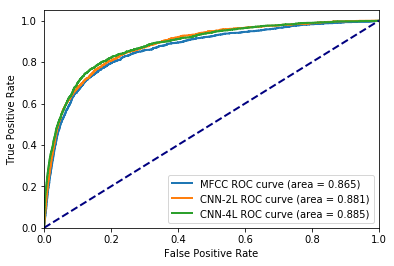

In [63]:
fpr_list, tpr_list, auc_list = [], [], []
for BASENAME, MODEL_LABEL in zip(BASENAMES, MODEL_LABELS):
    print '===================='
    print 'Model', MODEL_LABEL
    model = util_model.load_pretrained_model(BASENAME)
    if 'mfcc' in BASENAME:
        X_test_mfcc = util_model.mfcc_data(X_test)
        auc, pred_tags = util_model.test_model(model, X_test_mfcc, Y_test, batch_size=BATCH_SIZE)
    else:
        auc, pred_tags = util_model.test_model(model, X_test, Y_test, batch_size=BATCH_SIZE)
    
    fpr, tpr, roc_auc = util_eval.evaluate_predictions(Y_test, pred_tags, tags=tags)
    fpr_list.append(fpr), tpr_list.append(tpr), auc_list.append(roc_auc)
    
    # print results
    precision_list, true_y_list = util_eval.tag_precision(Y_test[:, country_idx], pred_tags[:, country_idx], tags[country_idx])
    print 'country prec@K ', np.mean(precision_list)
    tag_precision_list, true_y_list = util_eval.tag_precision(Y_test, pred_tags, tags)
    print 'tag prec@K ', np.mean(tag_precision_list)

util_eval.plot_multiple_auc(fpr_list, tpr_list, auc_list, label_list=MODEL_LABELS)

### AUC plots for best model

Loaded model from disk
0.884725382089
roc auc  0.884725382089
Five most/least accurate tags
[(0.98611111111111105, 'Acholi'), (0.99396863691194204, 'Saint Lucia'), (0.9963811821471652, 'Zambia'), (0.99758454106280192, 'Ga'), (0.99818840579710144, '1910')]
[(0.19219128329297824, 'Ecuador'), (0.35265700483091789, 'Baloch'), (0.36289346246973364, 'Lebanon'), (0.48867313915857608, 'Haiti'), (0.5, 'Gogrial (Rek cluster)')]


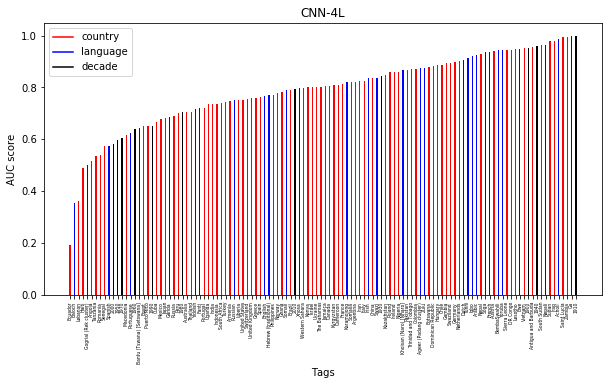

In [84]:
best_model = BASENAMES[2]
model = util_model.load_pretrained_model(best_model)
auc, pred_tags = util_model.test_model(model, X_test, Y_test, batch_size=BATCH_SIZE)
    
# Some plots with auc per tag
fpr, tpr, roc_auc = util_eval.evaluate_predictions(Y_test, pred_tags, tags=tags)
print 'roc auc ', roc_auc['micro']
roc_auc_per_tag = np.array([roc_auc[tag] for tag in tags])
# remove tags with 'nan' accuracy (it means they were not included in the test set)
non_zero_idx = np.where(np.isnan(roc_auc_per_tag)==False)[0]
roc_auc_per_tag = roc_auc_per_tag[non_zero_idx]
tags_to_plot = tags[non_zero_idx]
tag_colours_to_plot = tag_colours[non_zero_idx]
util_eval.plot_auc_per_class(roc_auc_per_tag, labels=tags_to_plot, color=tag_colours_to_plot, 
                             plot_legend=True, title=MODEL_LABEL)

print 'Five most/least accurate tags'
print list(zip(np.sort(roc_auc_per_tag)[-5:], tags_to_plot[np.argsort(roc_auc_per_tag)[-5:]]))
print list(zip(np.sort(roc_auc_per_tag)[:5], tags_to_plot[np.argsort(roc_auc_per_tag)[:5]]))


## Let's see what the predicted tags for some tracks look like

In [62]:
tags_to_test = ['United Kingdom', 'Zambia', 'Saint Lucia', 
                'Greece', 'Botswana', 'Ga', 'Spanish', 'Acholi']
N = 5
for test_tag in tags_to_test:
    idx_tag = np.where(tags==test_tag)[0]
    # select one track with this tag
    idx_track = np.where(Y_test[:, idx_tag]==1)[0][0]
    x = X_test[idx_track, :, :, :]
    x = x[np.newaxis, :, :, :]  # ensure 4-dim 
    pred_tags = model.predict(x)[0]
    top_N = np.argsort(pred_tags)[::-1][:N]
    print '========='
    print test_tag
    print zip(tags[top_N], pred_tags[top_N])

United Kingdom
[('1950', 0.99432993), ('Trinidad and Tobago', 0.39307979), ('English', 0.16630597), ('2010', 0.13648373), ('South Africa', 0.12508172)]
Zambia
[('Zambia', 0.41760564), ('Yoruba', 0.37828353), ('Nigeria', 0.1972924), ('1970', 0.17158704), ('1980', 0.066609778)]
Saint Lucia
[('1950', 0.40203083), ('Trinidad and Tobago', 0.35583329), ('1970', 0.33374906), ('Uganda', 0.099312611), ('1960', 0.065216474)]
Greece
[('English', 0.68603814), ('1970', 0.32518601), ('Russia', 0.22115658), ('United States', 0.20109652), ('1990', 0.19311215)]
Botswana
[('1990', 0.20562108), ('1980', 0.17176026), ('1970', 0.13801602), ('1960', 0.12864845), ('South Africa', 0.062658519)]
Ga
[('Yoruba', 0.90463752), ('Nigeria', 0.44803372), ('Spain', 0.39753768), ('Cuba', 0.25912842), ('Ghana', 0.2474094)]
Spanish
[('1960', 0.1488695), ('1950', 0.10438824), ('1990', 0.091311015), ('1970', 0.086829394), ('1980', 0.083964728)]
Acholi
[('1960', 0.23757839), ('1990', 0.11436841), ('1950', 0.096957378), ('In